### Code block 1: Package initialization
Import required packages, do not change.

In [24]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


In [25]:
torch.__version__

'1.12.1+cu113'

### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [26]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        if '1.4' in torch.__version__:
            self.output = self.conv2d_forward(input, self.weight) #1.4
        else:
            self.output = self._conv_forward(input, self.weight, self.bias) #1.5
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

(a) (10pt) Complete code block 3 for defining the adapted SimpleNN model. Note that customized
CONV and FC classes are provided in code block 2 to replace the nn.Conv2d and nn.Linear classes
in PyTorch respectively. The usage of the customized classes are exactly the same as their PyTorch
counterparts, the only difference is that in the customized class the input and output feature maps
of the layer will be stored in self.input and self.output respectively after the forward pass,
which will be helpful in question (b). After the code is completed, run through the block and
make sure the model forward pass in the end throw no errors. Please copy your code of the
completed SimpleNN class into the report PDF.

In [27]:
""" 
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = CONV(in_channels = 3, out_channels = 32, kernel_size = 5, stride=1, padding=2)    #Your code here
        self.conv2 = CONV(in_channels = 32, out_channels = 32, kernel_size = 5, stride=1, padding=2)    #Your code here
        self.conv3 = CONV(in_channels = 32, out_channels = 64, kernel_size = 5, stride=1, padding=2)    #Your code here
        self.fc1   = FC(in_features = 576, out_features = 64)     #Your code here
        self.fc2   = FC(in_features = 64, out_features = 10)     #Your code here

    def forward(self, x):
        # Forward pass computation
        # Conv 1
        out = F.relu(self.conv1.forward(x))    #Your code here
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 3, stride = 2)     #Your code here
        # Conv 2
        out = F.relu(self.conv2.forward(out))     #Your code here
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 3, stride = 2)    #Your code here
        # Conv 3
        out = F.relu(self.conv3.forward(out))    #Your code here
        # MaxPool
        out = F.max_pool2d(out, kernel_size = 3, stride = 2)    #Your code here
        # Flatten
        out = torch.flatten(out, start_dim = 1)    #Your code here
        # FC 1
        out = F.relu(self.fc1.forward(out))    #Your code here
        # FC 2
        out = F.relu(self.fc2.forward(out))    #Your code here
        return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)    #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

(b) (30pt) Complete the for-loop in code block 4 to print the shape of the input feature map, output
feature map and the weight tensor of the 5 convolutional and fully-connected layers when pro-
cessing a single input. Then compute the number of parameters and the number of MACs in each
layer with the shapes you get. In your report, use your results to fill in the blanks in Table 2.

In [28]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)    #Your code here

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input     #Your code here
        # Get the output feature map of the module as a NumPy array
        output = module.output     #Your code here
        # Get the weight of the module as a NumPy array
        weight = module.weight     #Your code here
        # Compute the number of parameters in the weight
        # Compute the number of MACs in the layer

        if isinstance(module, CONV):
          kernel_depth = input.shape[1]
          num_kernels = output.shape[1]
          #fmap_in (depth) * fmap_out (num kernels) * kernel_height * kernel_width
          num_Param = kernel_depth * num_kernels * module.kernel_size[0] * module.kernel_size[1]
          #Convolutional: fmap_in (depth) * fmap_out (num kernels) * kernel_height * kernel_width * output_height * output_weight
          num_MAC = kernel_depth * num_kernels * module.kernel_size[0] * module.kernel_size[1] * output.shape[2] * output.shape[3]     #Your code here
        else:
          #Input features * output features
          num_Param = input.shape[1] * output.shape[1]
          num_MAC = input.shape[1] * output.shape[1]
        
        if isinstance(module, CONV):
          print(f'{name:10} {str(input.shape):20}\t{str(output.shape):20}\t{str(weight.shape):20}\t{str(num_Param):10}\t{str(num_MAC):10}')
        else:
          print(f'{name:10} {str(input.shape):20}\t\t{str(output.shape):20}\t\t{str(weight.shape):20}\t\t{str(num_Param):10}\t{str(num_MAC):10}')

conv1      torch.Size([1, 3, 32, 32])	torch.Size([1, 32, 32, 32])	torch.Size([32, 3, 5, 5])	2400      	2457600   
conv2      torch.Size([1, 32, 15, 15])	torch.Size([1, 32, 15, 15])	torch.Size([32, 32, 5, 5])	25600     	5760000   
conv3      torch.Size([1, 32, 7, 7])	torch.Size([1, 64, 7, 7])	torch.Size([64, 32, 5, 5])	51200     	2508800   
fc1        torch.Size([1, 576])		torch.Size([1, 64]) 		torch.Size([64, 576])		36864     	36864     
fc2        torch.Size([1, 64]) 		torch.Size([1, 10]) 		torch.Size([10, 64])		640       	640       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

(a) (2pt) Complete the for-loop in code block 5 to plot the histogram of weight elements in each one
of the 5 convolutional and fully-connected layers.

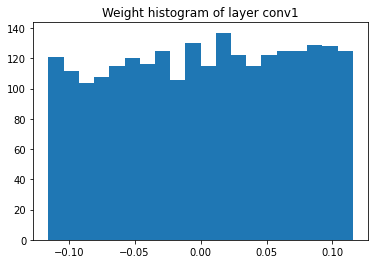

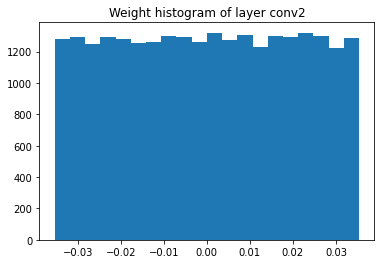

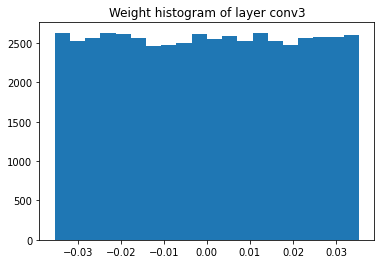

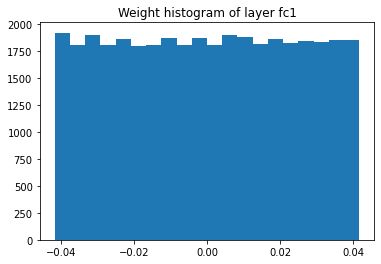

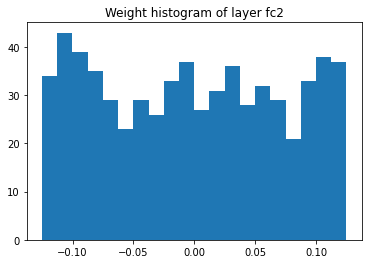

In [29]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy()    #Your code here
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.savefig(f'{name}_weight.png', dpi=300)
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

(b) (3pt) In code block 6, complete the code for backward pass, then complete the for-loop to plot the
histogram of weight elements’ gradients in each one of the 5 convolutional and fully-connected
layers.

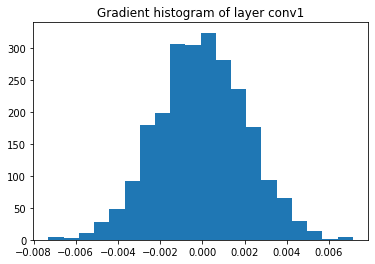

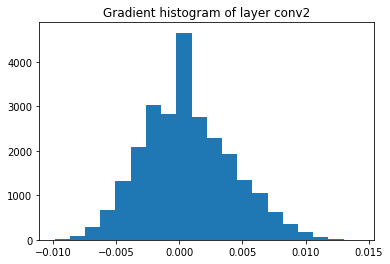

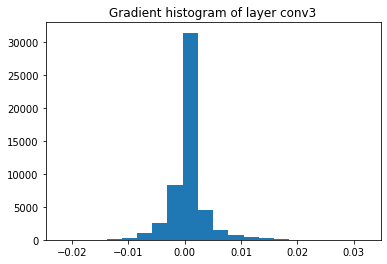

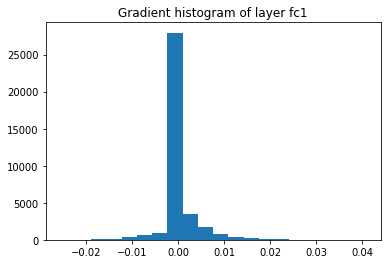

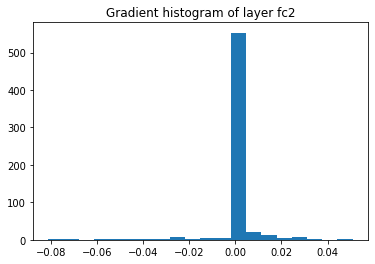

In [30]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(out, target)   #Your code here
# Backward pass for gradients
loss.backward(retain_graph=True)     #Your code here

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = np.array(module.weight.grad)    #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)        
        plt.savefig(name + '_grad.png',  dpi=300)
        plt.show()

### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

(c) (5pt) In code block 7, finish the code to set all the weights to 0. Perform forward and backward
pass again to get the gradients, and plot the histogram of weight elements’ gradients in each one
of the 5 convolutional and fully-connected layers. Comparing with the histograms you got in
(b), are there any differences? Briefly analyze the cause of the difference, and comment on how
will initializing CNN model with zero weights will affect the training process. (Note: The CNN
initialization methods will be introduced in Lecture 6.)
Lab 3 (Bonus 10 points)
7


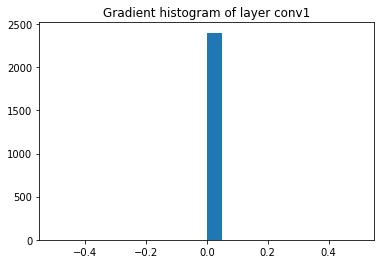

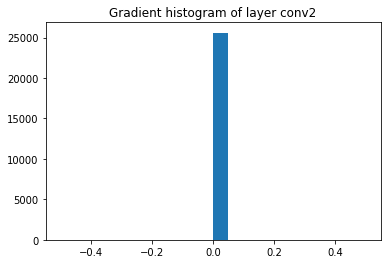

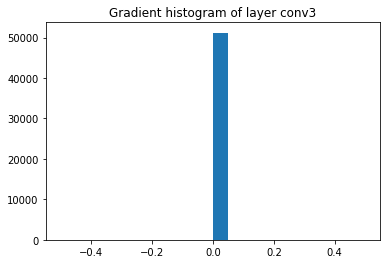

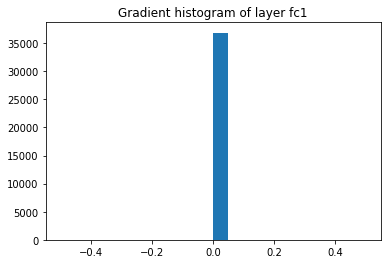

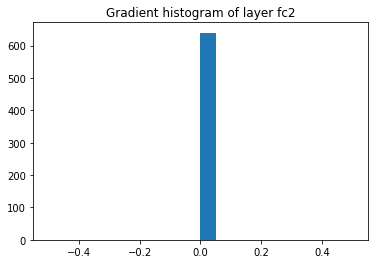

In [31]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
        module.weight = torch.nn.Parameter(data=torch.zeros(module.weight.shape))
        if module.bias != None:
          module.bias = torch.nn.Parameter(data=torch.zeros(module.bias.shape))   #Your code here
        

# Reset gradients
net.zero_grad()
        
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net.forward(data)     #Your code here
# Loss computation
loss = criterion(out, target)     #Your code here
# Backward pass
loss.backward(retain_graph=True)    #Your code here

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = np.array(module.weight.grad)     #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.savefig(name + '_0grad.png', dpi=300)
        plt.show()